In [1]:
#!pip install OpenCV-python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images -p /kaggle/working


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [31]:
from zipfile import ZipFile

data_path = r"C:\Users\shrouk qassem\Downloads\lung-and-colon-cancer-histopathological-images.zip"

with ZipFile(data_path,'r') as zip:
  zip.extractall()
print('The data set has been extracted.')


The data set has been extracted.


In [2]:
path = 'lung_colon_image_set/colon_image_sets'
classes = os.listdir(path)
classes


['colon_aca', 'colon_n']

In [3]:
# Create function to plot images from each class
def plot_image_from_each_class(path, classes):
  for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category ', fontsize=20)

    for i in range(3):
      k = np.random.randint(0, len(images))
      img = Image.open(f'{image_dir}/{images[k]}').resize((200, 200))
      ax[i].imshow(img)
      ax[i].set_axis_off()

    plt.show()


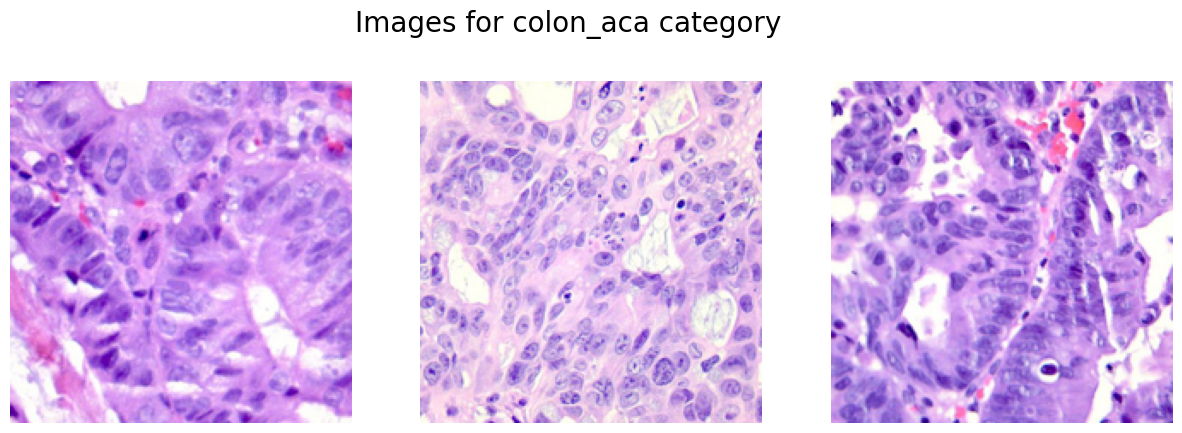

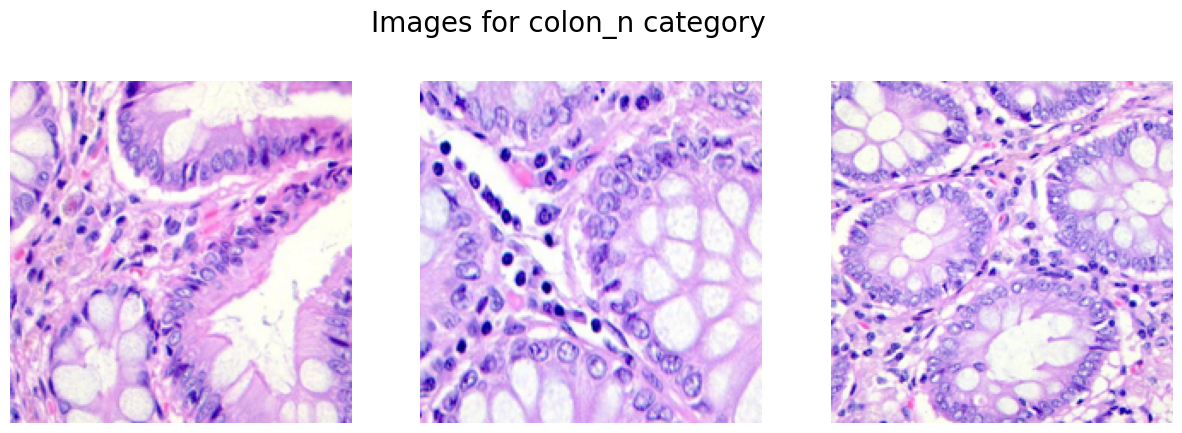

In [4]:
plot_image_from_each_class(path, classes)


# Data Preparation for Training

In this section, we will convert the given images into NumPy arrays of their pixels after resizing them because training a Deep Neural Network on large-size images is highly inefficient in terms of computational cost and time.

In [31]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64
num_classes = 2


we will split them into training and validation data so, that we can evaluate the performance of our model.

In [32]:
# Read data to a DataFrame from the directory
def read_data_from_directory(directory):
    data = []

    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Construct full file path
            filepath = os.path.join(root, file)

            # Determine label from the directory name (parent directory)
            label = os.path.basename(root)

            if label in classes:
                # Append file path and label to the list
                data.append({'filepaths': filepath, 'labels': label})
            else:
                print(f"Warning: Directory {root} not found in class list.")

    # Create DataFrame from the collected data
    df = pd.DataFrame(data)
    return df

# Use the path where the dataset was extracted
correct_path = path # Adjust path if needed
df = read_data_from_directory(correct_path)

df["labels"].value_counts()


labels
colon_aca    5000
colon_n      5000
Name: count, dtype: int64

In [33]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'],random_state=42)

we will split them into training and validation data so, that we can evaluate the performance of our model.

In [34]:
train_df, val_df = train_test_split(train_df, test_size=0.2,  stratify=train_df['labels'],random_state=42)

In [35]:
print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)
print("Val DataFrame shape:", val_df.shape)

Train DataFrame shape: (6400, 2)
Test DataFrame shape: (2000, 2)
Val DataFrame shape: (1600, 2)


In [36]:
# Generate image data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True

)

In [37]:
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 6400 validated image filenames belonging to 2 classes.


In [38]:
val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1600 validated image filenames belonging to 2 classes.


In [39]:
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2000 validated image filenames belonging to 2 classes.


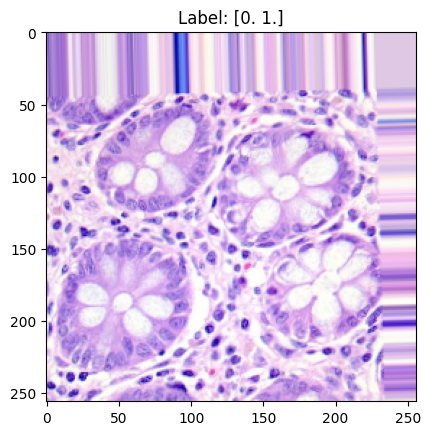

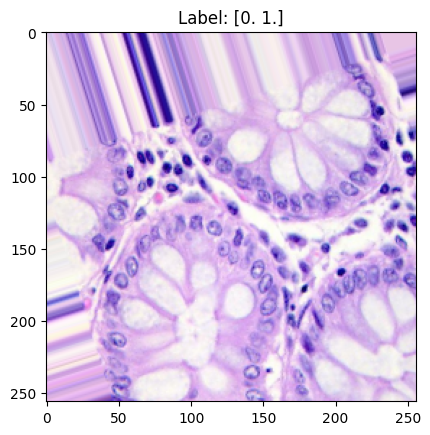

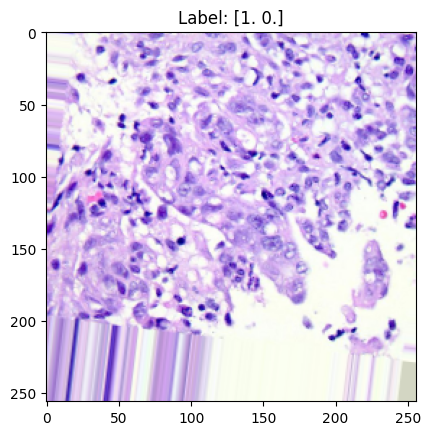

In [40]:


def verify_generator(generator, num_samples=3):
  """Verifies the labels in a data generator.

  Args:
    generator: The data generator.
    num_samples: The number of samples to inspect.
  """

  for i in range(num_samples):
    X, y = next(generator)

    # Visual inspection for image data
    if X.shape[3] == 3:  # Assuming RGB images
      import matplotlib.pyplot as plt
      plt.imshow(X[0])
      plt.title(f"Label: {y[0]}")
      plt.show()

    # Print numerical data and labels
    else:
      print(f"Sample {i+1}:")
      print(f"Features: {X[0]}")
      print(f"Label: {y[0]}")

    # Perform statistical analysis or other checks as needed


verify_generator(train_generator)


# Train Model

**Model Architecture**

We will implement a Sequential model which will contain the following parts:

*   Six Convolutional Layers followed by MaxPooling Layers each.
*   The Flatten layer to flatten the output of the convolutional layer.
*   Then we will have two fully connected layers followed by the output of the flattened layer.
*  We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.

* The final layer is the output layer which outputs soft probabilities for the two classes.

In [41]:
model = tf.keras.models.Sequential([

	layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
	layers.MaxPooling2D((2, 2)),

	layers.Conv2D(64, (3, 3), activation='relu'),
	layers.MaxPooling2D((2, 2)),

	layers.Conv2D(64, (3, 3), activation='relu'),
	layers.MaxPooling2D((2, 2)),

	layers.Conv2D(64, (3, 3), activation='relu'),
	layers.MaxPooling2D((2, 2)),

	layers.Conv2D(64, (3, 3), activation='relu'),
	layers.MaxPooling2D((2, 2)),

	layers.Conv2D(64, (3, 3), activation='relu'),
	layers.MaxPooling2D((2, 2)),

	layers.Flatten(),
	layers.Dense(64, activation='relu'),
	layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,682 (717.51 KB)

 Trainable params: 183,682 (717.51 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(optimizer='adam',
			loss='categorical_crossentropy',
			metrics=['accuracy'])

**Callbacks** are used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like ReduceLROnPlateau decreases learning rate further. Even then if model performance is not improving then training will be stopped by **EarlyStopping.**

In [43]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [44]:
history_model1 = model.fit(train_generator,
						validation_data=val_generator,
						epochs=EPOCHS,
						verbose=1,
						callbacks=[es, lr, myCallback()])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 533s 5s/step - accuracy: 0.5250 - loss: 0.6912 - val_accuracy: 0.7950 - val_loss: 0.5195 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.7265 - loss: 0.5425 - val_accuracy: 0.8012 - val_loss: 0.4217 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8368 - loss: 0.3628
 Validation accuracy has reached upto 					90% so, stopping further training.
100/100 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.8369 - loss: 0.3626 - val_accuracy: 0.9269 - val_loss: 0.2000 - learning_rate: 0.0010


In [45]:
def plot_accuracy_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

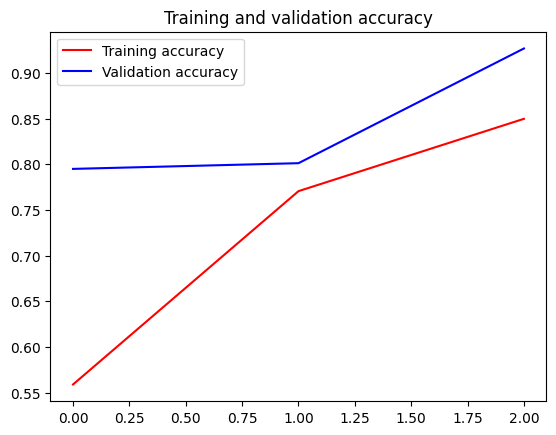

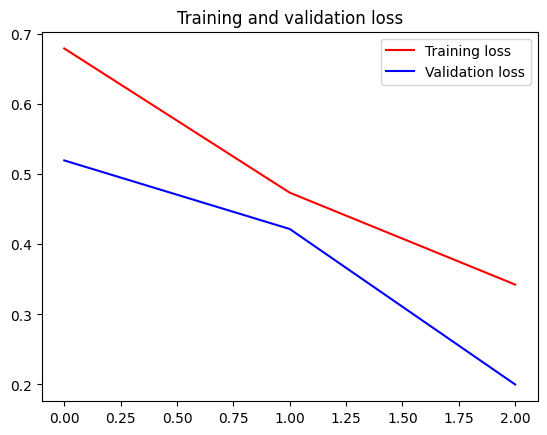

<Figure size 640x480 with 0 Axes>

In [46]:
plot_accuracy_loss(history_model1)

In [47]:
y_train_pred = model.predict(train_generator)
y_train_pred = np.argmax(y_train_pred, axis=1)

y_test_pred = model.predict(test_generator)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_val_pred = model.predict(val_generator)
y_val_pred = np.argmax(y_val_pred, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


In [48]:
from sklearn.metrics import classification_report
print("Train Classification Report")
print(classification_report(train_generator.classes, y_train_pred))
print("-------------------------------------------------------")
print("Test Classification Report")
print(classification_report(test_generator.classes, y_test_pred))
print("-------------------------------------------------------")
print("Validation Classification Report")
print(classification_report(val_generator.classes, y_val_pred))

Train Classification Report
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3200
           1       0.90      0.93      0.91      3200

    accuracy                           0.91      6400
   macro avg       0.91      0.91      0.91      6400
weighted avg       0.91      0.91      0.91      6400

-------------------------------------------------------
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1000
           1       0.90      0.94      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

-------------------------------------------------------
Validation Classification Report
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       800
           1       0.91      0.95    

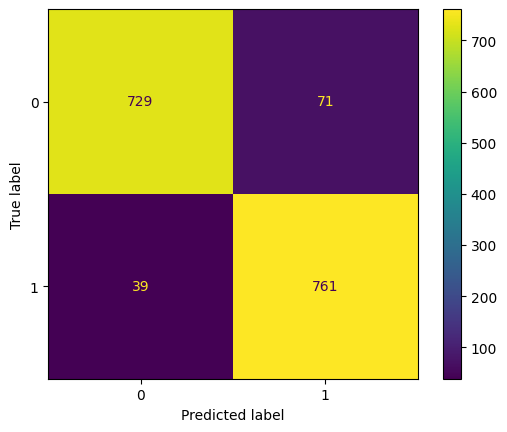

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(val_generator.classes, y_val_pred)

# Transfare Learning

* We will use pre-trained weight for an Inception network which is trained on imagenet dataset. This dataset contains millions of images for around 1000 classes of images.

**Model Architecture**

We will implement a model using the  Functional API of Keras which will contain the following parts:

* The base model is the Inception model in this case.
* The Flatten layer flattens the output of the base model’s output.
* Then we will have two fully connected layers followed by the output of the flattened layer.
* We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.
* The final layer is the output layer which outputs soft probabilities for the three classes. 
from tensorflow.keras.applications.

In [50]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 

pre_trained_model = InceptionV3( 
	input_shape = (IMG_SIZE, IMG_SIZE, 3), 
	weights = 'imagenet', 
	include_top = False
)


In [51]:
len(pre_trained_model.layers)


311

* This is how deep this model is this also justifies why this model is highly effective in extracting useful features from images which helps us to build classifiers.

* The parameters of a model we import are already trained on millions of images and for weeks so, we do not need to train them again.

In [52]:
for layer in pre_trained_model.layers: 
    layer.trainable = False


In [53]:
# Mixed7 layer output shape 
last_layer = pre_trained_model.get_layer('mixed7') 

last_output = last_layer.output
print("last layer output shape: ", last_output.shape)



last layer output shape:  (None, 14, 14, 768)


In [54]:
x = layers.Flatten()(last_output) 

x = layers.Dense(256,activation='relu')(x) 
x = layers.BatchNormalization()(x) 

x = layers.Dense(128,activation='relu')(x) 
x = layers.Dropout(0.3)(x) 
x = layers.BatchNormalization()(x) 

output = layers.Dense(num_classes, activation='softmax')(x) 

model_tl = keras.Model(pre_trained_model.input, output)


In [55]:
model_tl.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [56]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [57]:
history_tl = model_tl.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS,
                        verbose=1,
                        callbacks=[es, lr, myCallback()])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9355 - loss: 0.1598
 Validation accuracy has reached upto 					90% so, stopping further training.
100/100 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - accuracy: 0.9358 - loss: 0.1590 - val_accuracy: 0.9806 - val_loss: 0.0562 - learning_rate: 0.0010


In [58]:
y_train_pred_tl = model_tl.predict(train_generator)
y_train_pred_tl = np.argmax(y_train_pred_tl, axis=1)

y_test_pred_tl = model_tl.predict(test_generator)
y_test_pred_tl = np.argmax(y_test_pred_tl, axis=1)

y_val_pred_tl = model_tl.predict(val_generator)
y_val_pred_tl = np.argmax(y_val_pred_tl, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step


In [59]:
print("Train Classification Report")
print(classification_report(train_generator.classes, y_train_pred_tl))
print("-------------------------------------------------------")
print("Test Classification Report")
print(classification_report(test_generator.classes, y_test_pred_tl))
print("-------------------------------------------------------")
print("Validation Classification Report")
print(classification_report(val_generator.classes, y_val_pred_tl))

Train Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3200
           1       0.96      1.00      0.98      3200

    accuracy                           0.98      6400
   macro avg       0.98      0.98      0.98      6400
weighted avg       0.98      0.98      0.98      6400

-------------------------------------------------------
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1000
           1       0.96      1.00      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

-------------------------------------------------------
Validation Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       800
           1       0.97      1.00    

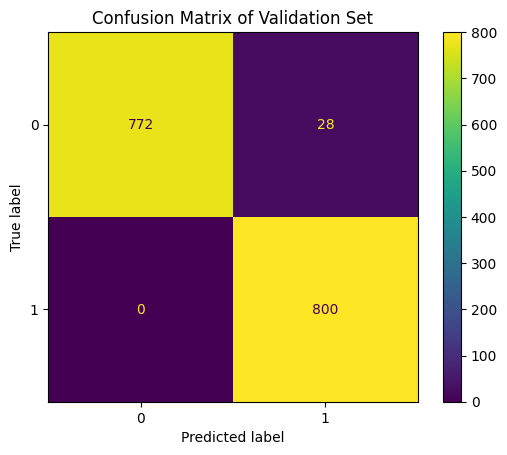

In [60]:
ConfusionMatrixDisplay.from_predictions(val_generator.classes, y_val_pred_tl)
# title the plot
plt.title('Confusion Matrix of Validation Set')
# show the plot
plt.show()  